In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import warnings
import tensorflow as tf
import seaborn as sb
import librosa
import IPython.display as ipd
import librosa.display
import json
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

### Testing an audio file to check if it is working fine while loading

In [ ]:
path = os.getcwd()
file = "Solely Urdu Dataset/Angry"
new = os.path.join(path, file)
os.chdir(new)

In [4]:
ipd.Audio(os.listdir()[0])

### Plotting a waveplot of an audio to understand how amplitude varies with time

In [ ]:
y, sr = librosa.load(os.listdir()[0], duration=3.00)
mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=13)
delta_mfccs = librosa.feature.delta(mfccs)
delta_delta_mfccs = librosa.feature.delta(mfccs, order=2)
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta_delta_mfccs))
print(comprehensive_mfccs.shape)
print(librosa.display.waveplot(comprehensive_mfccs, sr=sr))

In [ ]:
ps = librosa.feature.melspectrogram(y=y, sr=sr)
print(librosa.display.waveplot(ps, sr=sr))

In [ ]:
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

### Creating Mel Frequency Cepstral Coefficients dataset for each voice sample in a JSON file

In [ ]:
DATASET_PATH = "D:/Solely Urdu Dataset/"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 1
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=3):
    """Extracts MFCCs from Urdu voice dataset and saves them into a json file along witgh emotion labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all voice sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a voice sub-folder level
        if dirpath is not dataset_path:

            # save voice label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in voice sub-dir
            for f in filenames:

            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish],
                                                sample_rate, 
                                                n_mfcc=num_mfcc, 
                                                n_fft=n_fft, 
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))


    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=3)

### Loading Data

In [20]:
DATA_PATH = "D:/Urdu_Voice/data.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    print("Data succesfully loaded!")

    return  x, y

x, y = load_data(DATA_PATH)

Data succesfully loaded!


In [21]:
X, y = shuffle(x, y, random_state=0)

In [22]:
x.shape, y.shape

((1197, 15, 13), (1197,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Splitting data into validation, training, test

In [4]:
def prepare_datasets(test_size, validation_size):
    
    X, y = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    #X_train = X_train[..., np.newaxis]
    #X_validation = X_validation[..., np.newaxis]
    #X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

Data succesfully loaded!


### Changing Data Shape and Adding new axis for Conv2D

In [6]:
X_train_Conv2D = X_train[..., np.newaxis]
X_validation_Conv2D = X_validation[..., np.newaxis]
X_test_Conv2D = X_test[..., np.newaxis]

In [23]:
X_conv2D = X[..., np.newaxis]

In [24]:
X_conv2D.shape

(1197, 15, 13, 1)

In [25]:
X.shape

(1197, 15, 13)

### Convolutional 2D Neural Network Model

In [26]:
def Conv2D_Model():
    model_conv2D = keras.Sequential()

    model_conv2D.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_conv2D.shape[1], X_conv2D.shape[2], 1)))
    #model_conv2D.add(keras.layers.BatchNormalization())
    model_conv2D.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))


    model_conv2D.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    #model_conv2D.add(keras.layers.BatchNormalization())
    model_conv2D.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))


    model_conv2D.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    #model_conv2D.add(keras.layers.BatchNormalization())
    model_conv2D.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model_conv2D.add(keras.layers.Flatten())
    
    model_conv2d_lstm = keras.Sequential()

    model_conv2d_lstm.add(keras.layers.TimeDistributed(model_conv2D, input_shape=(None, X_conv2D.shape[1], X_conv2D.shape[2], 1)))

    model_conv2d_lstm.add(keras.layers.LSTM(64, activation='relu'))

    model_conv2d_lstm.add(keras.layers.Dense(64, activation='relu'))
    model_conv2d_lstm.add(keras.layers.Dense(4, activation='softmax'))
    
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model_conv2d_lstm.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model_conv2d_lstm

In [177]:
model_conv2d_lstm.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 64)          35264     
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 260       
Total params: 72,708
Trainable params: 72,708
Non-trainable params: 0
_________________________________________________________________


### Changing Data Shape for Training

In [13]:
X_train_Conv2D = np.reshape(X_train_Conv2D, (717, 1, 15, 13, 1))
X_validation_Conv2D = np.reshape(X_validation_Conv2D, (180, 1, 15, 13, 1))
X_test_Conv2D = np.reshape(X_test_Conv2D, (300, 1, 15, 13, 1))

In [14]:
X_validation_Conv2D.shape

(180, 1, 15, 13, 1)

In [15]:
history_conv2D = model_conv2d_lstm.fit(X_train_Conv2D, y_train, batch_size=16, epochs=100, validation_data=(X_validation_Conv2D, y_validation))

Epoch 1/100
45/45 [==============================] - 2s 14ms/step - loss: 1.3429 - accuracy: 0.4059 - val_loss: 1.1044 - val_accuracy: 0.6333
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 0.9341 - accuracy: 0.6625 - val_loss: 0.8216 - val_accuracy: 0.6944
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 0.7026 - accuracy: 0.7503 - val_loss: 0.6954 - val_accuracy: 0.7500
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 0.6038 - accuracy: 0.7755 - val_loss: 0.6214 - val_accuracy: 0.7667
Epoch 5/100
45/45 [==============================] - 0s 8ms/step - loss: 0.5223 - accuracy: 0.7978 - val_loss: 0.6216 - val_accuracy: 0.7722
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 0.4967 - accuracy: 0.8159 - val_loss: 0.5369 - val_accuracy: 0.7944
Epoch 7/100
45/45 [==============================] - 0s 7ms/step - loss: 0.4378 - accuracy: 0.8298 - val_loss: 0.5430 - val_accuracy: 0.7944
Epoch 8/100


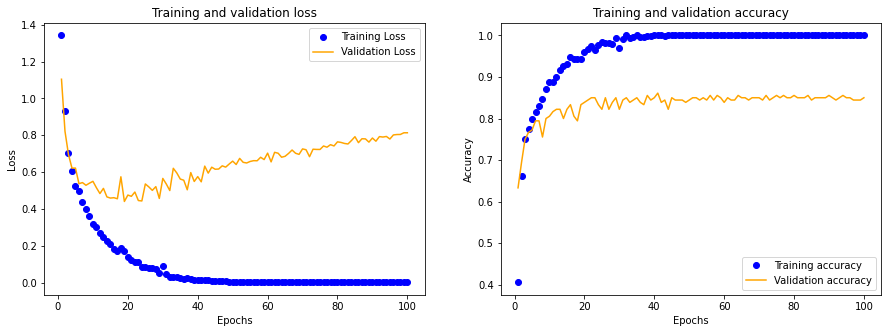

In [16]:
history_dict = history_conv2D.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [17]:
test_loss_Conv2D, test_acc_Conv2D = model_conv2d_lstm.evaluate(X_test_Conv2D, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.9925 - accuracy: 0.8300


### Convolutional 1D Model

In [27]:
def Conv1D_Model():
    model_conv1D = keras.Sequential()
    
    model_conv1D.add(keras.layers.Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model_conv1D.add(keras.layers.MaxPool1D(2, strides=2, padding='same'))

    model_conv1D.add(keras.layers.Conv1D(64, 3, activation='relu'))
    model_conv1D.add(keras.layers.MaxPool1D(2, strides=2, padding='same'))

    model_conv1D.add(keras.layers.Conv1D(64, 3, activation='relu'))
    model_conv1D.add(keras.layers.MaxPool1D(2, strides=1, padding='same'))
    #model_conv1D.add(keras.layers.GlobalMaxPooling1D())

    model_conv1D.add(keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))

    model_conv1D.add(keras.layers.Dense(64, activation='relu'))
    #model_conv1D.add(keras.layers.Dropout(0.3))
    model_conv1D.add(keras.layers.Dense(4, activation='softmax'))

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model_conv1D.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model_conv1D

In [165]:
model_conv1D.summary()

(None, 13, 32)
(None, 7, 32)
(None, 5, 64)
(None, 3, 64)
(None, 1, 64)
(None, 1, 64)
(None, 64)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 13, 32)            1280      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 5, 64)             6208      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 1, 64)             0         
_______________________

In [163]:
history_conv1D = model_conv1D.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_validation, y_validation))

Epoch 1/100
45/45 [==============================] - 4s 17ms/step - loss: 1.3737 - accuracy: 0.3752 - val_loss: 1.2193 - val_accuracy: 0.4556
Epoch 2/100
45/45 [==============================] - 0s 6ms/step - loss: 1.1922 - accuracy: 0.4854 - val_loss: 1.1602 - val_accuracy: 0.4889
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 1.1146 - accuracy: 0.5272 - val_loss: 1.0955 - val_accuracy: 0.5389
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 1.0372 - accuracy: 0.5802 - val_loss: 1.0602 - val_accuracy: 0.6111
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 0.9765 - accuracy: 0.6095 - val_loss: 1.0102 - val_accuracy: 0.6222
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.9240 - accuracy: 0.6457 - val_loss: 0.9747 - val_accuracy: 0.6333
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 0.8709 - accuracy: 0.6513 - val_loss: 0.9247 - val_accuracy: 0.6444
Epoch 8/100


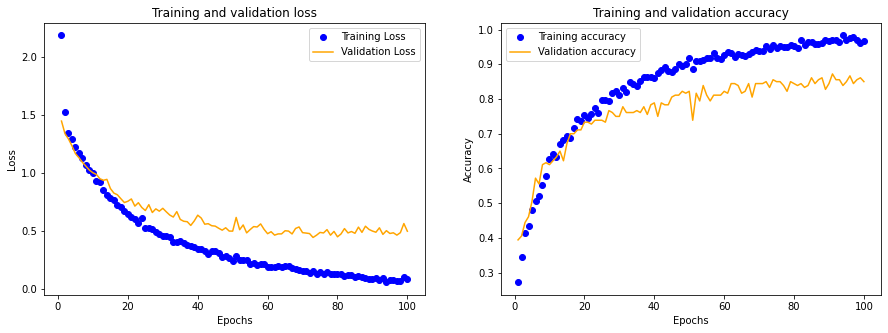

In [87]:
history_dict = history_conv1D.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [88]:
test_loss_conv1D, test_acc_conv1D = model_conv1D.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.7294 - accuracy: 0.8200


In [69]:
X_train.shape, X_test.shape, X_validation.shape

((717, 15, 13), (300, 15, 13), (180, 15, 13))

### LSTM Model

In [2]:
model_lstm = keras.models.Sequential()

In [8]:
model_lstm.add(keras.layers.Bidirectional(layers.LSTM(32), input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(keras.layers.Dense(64, activation='relu'))
#model_lstm.add(keras.layers.Dropout(0.3))
model_lstm.add(keras.layers.Dense(4, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                11776     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 16,196
Trainable params: 16,196
Non-trainable params: 0
_________________________________________________________________


In [9]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_validation, y_validation))

Epoch 1/100
45/45 [==============================] - 4s 28ms/step - loss: 1.5448 - accuracy: 0.2831 - val_loss: 1.4970 - val_accuracy: 0.3056
Epoch 2/100
45/45 [==============================] - 0s 10ms/step - loss: 1.4585 - accuracy: 0.3138 - val_loss: 1.4345 - val_accuracy: 0.3111
Epoch 3/100
45/45 [==============================] - 0s 11ms/step - loss: 1.3968 - accuracy: 0.3570 - val_loss: 1.3830 - val_accuracy: 0.3667
Epoch 4/100
45/45 [==============================] - 0s 10ms/step - loss: 1.3471 - accuracy: 0.3891 - val_loss: 1.3367 - val_accuracy: 0.4111
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 1.3060 - accuracy: 0.42 - 0s 10ms/step - loss: 1.3030 - accuracy: 0.4310 - val_loss: 1.2981 - val_accuracy: 0.4333
Epoch 6/100
45/45 [==============================] - 0s 11ms/step - loss: 1.2641 - accuracy: 0.4700 - val_loss: 1.2631 - val_accuracy: 0.4778
Epoch 7/100
45/45 [==============================] - 0s 10ms/step - loss: 1.2271 - accuracy: 0.5063 - val_

45/45 [==============================] - 0s 10ms/step - loss: 0.3992 - accuracy: 0.8745 - val_loss: 0.5870 - val_accuracy: 0.7889
Epoch 59/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3928 - accuracy: 0.8787 - val_loss: 0.5801 - val_accuracy: 0.8056
Epoch 60/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3873 - accuracy: 0.8801 - val_loss: 0.5780 - val_accuracy: 0.7944
Epoch 61/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3816 - accuracy: 0.8815 - val_loss: 0.5769 - val_accuracy: 0.7944
Epoch 62/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3761 - accuracy: 0.8828 - val_loss: 0.5745 - val_accuracy: 0.7944
Epoch 63/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3710 - accuracy: 0.8815 - val_loss: 0.5703 - val_accuracy: 0.7944
Epoch 64/100
45/45 [==============================] - 0s 10ms/step - loss: 0.3658 - accuracy: 0.8842 - val_loss: 0.5670 - val_accuracy: 0.8000
Epoch 65/100

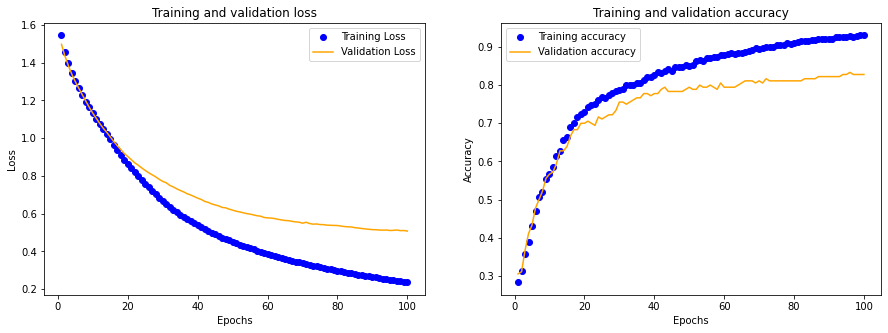

In [10]:
history_dict = history_lstm.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [11]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.7867


### K-Fold Cross Validation

In [28]:
def kfold_CV(model_func, n_splits, X, y, epochs):
    
    num_test_samples = len(X) // n_splits
    all_accuracy_scores = []
    train_accuracy_scores = []
    
    for i in range(n_splits):
        print('processing fold #', i)
        test_data = X[i * num_test_samples: (i + 1) * num_test_samples]
        
        test_targets = y[i * num_test_samples: (i + 1) * num_test_samples]
        
        partial_train_data = np.concatenate([X[:i * num_test_samples], X[(i + 1) * num_test_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([y[:i * num_test_samples], y[(i + 1) * num_test_samples:]], axis=0)
        
        model = model_func()
        history = model.fit(partial_train_data, partial_train_targets, epochs=epochs, verbose=0)   
        train_acc = history.history['accuracy']
        train_accuracy_scores.append(train_acc) 
        
        loss, acc = model.evaluate(test_data, test_targets, verbose=0)     
        all_accuracy_scores.append(acc)
    
    return train_accuracy_scores, all_accuracy_scores

In [29]:
k = 10
num_epochs = 100

conv1D_training_accuracies, conv1D_test_accuracies = kfold_CV(Conv1D_Model, k, X, y, num_epochs)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [30]:
print(conv1D_test_accuracies) 
print("-------------------------------------------------------------------------------------------------------------")
print("Average accuracy of Conv1D + LSTM Model is: ", np.mean(conv1D_test_accuracies))

[0.8655462265014648, 0.8403361439704895, 0.8655462265014648, 0.848739504814148, 0.8571428656578064, 0.8823529481887817, 0.8151260614395142, 0.8655462265014648, 0.831932783126831, 0.8739495873451233]
-------------------------------------------------------------------------------------------------------------
Average accuracy of Conv1D + LSTM Model is:  0.8546218574047089


In [33]:
X_conv2D_training_time_shape = np.reshape(X_conv2D, (X_conv2D.shape[0], 1, 15, 13, 1))
conv2D_training_accuracies, conv2D_test_accuracies = kfold_CV(Conv2D_Model, k, X_conv2D_training_time_shape, y, num_epochs)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [34]:
print(conv2D_test_accuracies) 
print("-------------------------------------------------------------------------------------------------------------")
print("Average accuracy of Conv2D + LSTM Model is: ", np.mean(conv2D_test_accuracies))

[0.7899159789085388, 0.8403361439704895, 0.8403361439704895, 0.8403361439704895, 0.8655462265014648, 0.8655462265014648, 0.8235294222831726, 0.8571428656578064, 0.924369752407074, 0.8655462265014648]
-------------------------------------------------------------------------------------------------------------
Average accuracy of Conv2D + LSTM Model is:  0.8512605130672455


In [ ]:
with open('')

In [22]:
def predict(model, X, y):

    X = X[np.newaxis, ...] 

    print (X.shape)
    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(model, X_to_predict, y_to_predict)

(1, 15, 13, 1)
Target: 1, Predicted label: [2]


In [24]:
X_to_predict.shape

(15, 13, 1)

In [12]:
pred = model.predict(X_test)

In [13]:
pred2 = np.argmax(pred, axis=1)

In [14]:
y_test

array([2, 0, 0, 2, 0, 3, 2, 2, 0, 2, 2, 1, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0,
       1, 1, 0, 2, 0, 1, 2, 2, 0, 1, 2, 3, 3, 3, 3, 1, 0, 2, 0, 1, 3, 0,
       1, 0, 0, 3, 2, 0, 1, 1, 3, 1, 3, 2, 2, 0, 1, 0, 2, 2, 2, 1, 3, 0,
       1, 1, 2, 3, 0, 0, 1, 2, 3, 1, 2, 3, 2, 1, 2, 0, 1, 0, 0, 3, 1, 0,
       3, 2, 1, 3, 1, 3, 2, 2, 2, 3, 1, 3, 1, 1, 3, 2, 3, 3, 0, 0, 3, 0,
       1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0, 2, 1, 1, 3, 0,
       3, 3, 1, 1, 0, 2, 3, 2, 1, 0, 0, 0, 0, 3, 3, 2, 3, 0, 0, 1, 3, 2,
       2, 0, 3, 3, 2, 2, 1, 3, 1, 1, 3, 2, 3, 1, 0, 0, 2, 2, 0, 3, 3, 2,
       1, 0, 0, 1, 1, 2, 1, 2, 1, 3, 0, 2, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1,
       2, 3, 1, 0, 2, 2, 0, 3, 2, 0, 2, 1, 1, 3, 1, 1, 2, 1, 2, 3, 1, 1,
       1, 1, 2, 2, 3, 2, 1, 0, 1, 3, 0, 3, 0, 2, 3, 1, 2, 3, 2, 3, 3, 2,
       3, 2, 3, 0, 1, 2, 0, 2, 0, 3, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1, 0,
       0, 0, 1, 1, 3, 3, 3, 2, 0, 0, 0, 0, 3, 1, 1, 3, 3, 3, 3, 1, 1, 2,
       2, 0, 3, 3, 1, 0, 2, 0, 1, 2, 1, 0, 0, 0])

In [15]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, pred2)

In [16]:
Result = pd.DataFrame(conf_mat, 
                      index=['Angry', 'Happy', 'Nuetral', 'Sad'], 
                      columns=['Angry', 'Happy', 'Nuetral', 'Sad'])

In [17]:
Result

,Angry,Happy,Nuetral,Sad
Angry,74,4,0,0
Happy,8,57,11,2
Nuetral,6,10,56,1
Sad,0,4,4,63


In [ ]:
data = {'ANN':20, '':15, 'Java':30,
        'Python':35}
courses = ['ANN', 'CNN']
values = [test_acc1, test_acc]
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy with Models")
plt.show()

In [20]:
model.save('voice_model.HDF5')

INFO:tensorflow:Assets written to: voice_model.HDF5\assets


In [90]:
x.shape

(1197, 15, 13)